In [ ]:
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install medmnist
clear_output()

In [ ]:
from resnet import ResNet50
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt
from medmnist import dataset
import numpy as np
import torchvision.transforms as transforms
import random
import os

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
EPOCHS = 10
img_size = 28
lr = 0.001

model_store_path = "/content/drive/MyDrive/DLAM/DLAM-Project/models/"

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    dataset.OrganAMNIST(
        # root=data_dir,
        split='train',
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    ),
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset.OrganAMNIST(
        # root=data_dir,
        split='test',
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    ),
    batch_size=batch_size,
    shuffle=False
)

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz


In [ ]:
num_classes = len(train_dataloader.dataset.info["label"])
classes = list(train_dataloader.dataset.info["label"])
model = ResNet50(num_classes=num_classes, channels=1).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, last_epoch=-1, verbose=False)


In [ ]:
def training(dataloader, device, model, criterion, scheduler):
    model.train()
    losses = []
    running_loss = 0

    pbar = tqdm(dataloader, unit="batch", desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.view(-1).to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = sum(losses)/len(losses)
    scheduler.step()

    return model, scheduler, avg_loss

def classify_dataloader(dataloader, device, model):
    model.eval()
    y_pred = []
    y_true = []
    losses = []
    running_loss = 0
    pbar = tqdm(dataloader, unit="batch", desc="Evaluating")

    with torch.no_grad():

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.view(-1).to(device)
            optimizer.zero_grad()

            outputs = model(inputs)

            labels_predicted = outputs.argmax(1)
            for prediction, label in zip(labels_predicted, labels):
                y_pred.append(int(prediction))
                y_true.append(int(label))

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            running_loss += loss.item()

    avg_loss = sum(losses)/len(losses)
    return y_true, y_pred, avg_loss

In [ ]:
losses = {"train_loss": [],
          "test_loss": [],
          "test_predictions": [],
          "model_path": [],
          "test_true_labels": []}

for epoch in range(1, EPOCHS+1):
    print(f"Processing epoch {epoch}:")
    model, scheduler, avg_loss_train = training(train_dataloader, device, model, criterion, scheduler)
    print(f"Avg train loss: {round(avg_loss_train, 3)}")

    y_true, y_pred, avg_loss_test = classify_dataloader(test_dataloader, device, model)
    losses["train_loss"].append(avg_loss_train)
    print(f"Avg test loss: {round(avg_loss_test, 3)}")

    losses["test_loss"].append(avg_loss_test)
    losses["test_predictions"].append([y_pred])
    losses["test_true_labels"].append([y_true])

    losses["model_path"].append(f"{model_store_path}ResNet50original_epoch_{epoch}")

    torch.save(model, f"{model_store_path}ResNet50original_epoch_{epoch}")
    # Save the losses dictionary
    with open(f"{model_store_path}losses_original.pkl", "wb") as f:
        pickle.dump(losses, f)
    print("\n"*2)

print('Training Done')

Processing epoch 1:


Training: 100%|██████████| 136/136 [00:15<00:00,  8.91batch/s]


Avg train loss: 0.449


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.45batch/s]


Avg test loss: 0.563



Processing epoch 2:


Training: 100%|██████████| 136/136 [00:14<00:00,  9.47batch/s]


Avg train loss: 0.109


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.01batch/s]


Avg test loss: 0.618



Processing epoch 3:


Training: 100%|██████████| 136/136 [00:14<00:00,  9.60batch/s]


Avg train loss: 0.084


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.45batch/s]


Avg test loss: 0.575



Processing epoch 4:


Training: 100%|██████████| 136/136 [00:13<00:00,  9.79batch/s]


Avg train loss: 0.062


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.06batch/s]


Avg test loss: 0.655



Processing epoch 5:


Training: 100%|██████████| 136/136 [00:13<00:00,  9.82batch/s]


Avg train loss: 0.058


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.13batch/s]


Avg test loss: 0.552



Processing epoch 6:


Training: 100%|██████████| 136/136 [00:14<00:00,  9.57batch/s]


Avg train loss: 0.035


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.23batch/s]


Avg test loss: 0.597



Processing epoch 7:


Training: 100%|██████████| 136/136 [00:14<00:00,  9.68batch/s]


Avg train loss: 0.034


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.77batch/s]


Avg test loss: 0.486



Processing epoch 8:


Training: 100%|██████████| 136/136 [00:13<00:00,  9.82batch/s]


Avg train loss: 0.004


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.29batch/s]


Avg test loss: 0.571



Processing epoch 9:


Training: 100%|██████████| 136/136 [00:14<00:00,  9.64batch/s]


Avg train loss: 0.003


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.97batch/s]


Avg test loss: 0.604



Processing epoch 10:


Training: 100%|██████████| 136/136 [00:14<00:00,  9.69batch/s]


Avg train loss: 0.009


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 13.10batch/s]


Avg test loss: 0.622



Training Done


In [ ]:
file = open(f"{model_store_path}losses_original.pkl", "rb")
losses = pickle.load(file)

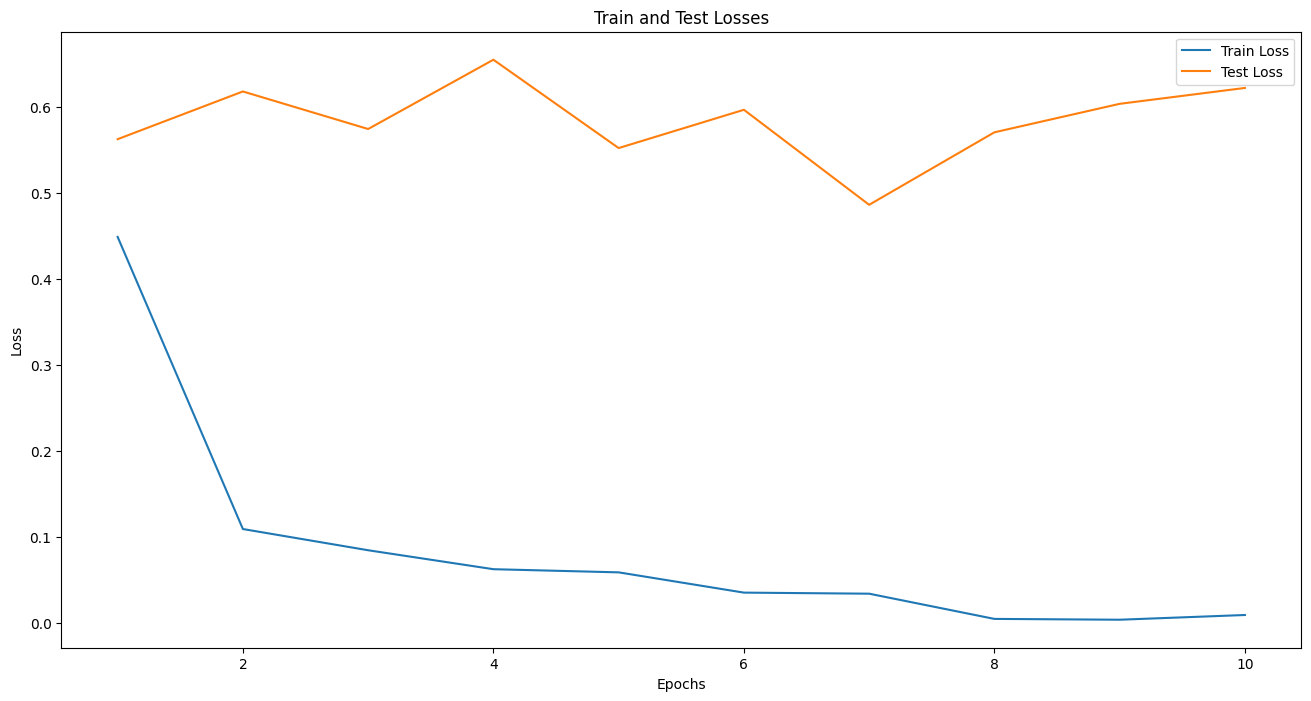

In [ ]:
# Create x-axis values (epochs)
epochs = range(1, len(losses['train_loss']) + 1)

# Set the figure size
plt.figure(figsize=(16, 8))
# Plot train and test losses
plt.plot(epochs, losses['train_loss'], label='Train Loss')
plt.plot(epochs, losses['test_loss'], label='Test Loss')


# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()

# Show the plot
plt.show()

In [ ]:
y_pred_min = losses["test_predictions"][np.argmin(losses["train_loss"])][0]
y_true_min = losses["test_true_labels"][np.argmin(losses["train_loss"])][0]

report = classification_report(y_true_min, y_pred_min)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.94      0.86      0.90       784
           2       0.93      0.88      0.90       793
           3       0.99      0.81      0.89       785
           4       0.71      0.75      0.73      2064
           5       0.87      0.77      0.82      1965
           6       0.96      0.97      0.97      3285
           7       0.96      0.97      0.96      1747
           8       0.98      0.95      0.97      1813
           9       0.81      0.91      0.86      1622
          10       0.80      0.85      0.82      1884

    accuracy                           0.88     17778
   macro avg       0.89      0.87      0.88     17778
weighted avg       0.88      0.88      0.88     17778

